In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable

## only need the nu_spec module
import nu_spec

## to fit the model
from scipy.optimize import minimize

## for MCMC
import emcee
import corner

%matplotlib notebook

# Read in .pha file, create spectrum, compare with XSPEC

In [2]:
d_pha = 'spectralData/'
f_pha = 'nu80415201001A06_chu2_S_cl_grade0_sr.pha'
channel, channel_error, counts, counts_error = nu_spec.nustar_ctsSpec(d_pha+f_pha)

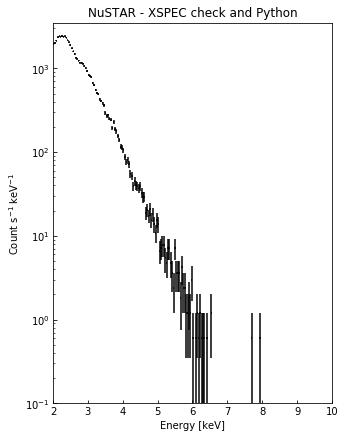

In [3]:
fig = plt.figure(figsize=(5,7))
ax = fig.gca()
ax.tick_params(axis='both', which='both', direction='in')

## plot spectrum created from Python
plt.errorbar(channel, 
             counts, 
             xerr=channel_error, 
             yerr=counts_error, 
             color='k', 
             fmt='.',
             markersize=0.01)
ax.set_xlim([2,10])
ax.set_ylim([0.1,3500])
ax.set_title('NuSTAR - XSPEC check and Python')
ax.set_ylabel('Count s$^{-1}$ keV$^{-1}$')
ax.set_yscale('log')
ax.set_xlabel('Energy [keV]')

plt.show()

# Read in .arf file

In [4]:
d_arf = 'spectralData/'
f_arf = 'nu80415201001A06_chu2_S_cl_grade0_sr.arf'
e_lo, e_hi, eff_area = nu_spec.read_arf(d_arf+f_arf)
e_mid = (e_hi + e_lo)/2 ## same as channel above

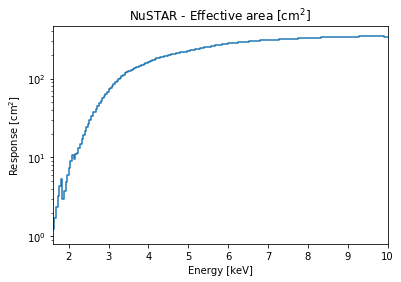

In [5]:
fig = plt.figure()

plt.plot(e_mid, eff_area,drawstyle='steps-mid')
plt.xlim([1.6,10])
plt.title('NuSTAR - Effective area [cm$^{2}$]')
plt.ylabel('Response [cm$^{2}$]')
plt.xlabel('Energy [keV]')
plt.yscale('log')
plt.show()

# Read in .rmf file

In [6]:
d_rmf = 'spectralData/'
f_rmf = 'nu80415201001A06_chu2_S_cl_grade0_sr.rmf'
e_lo, e_hi, ngrp, fchan, nchan, matrix = nu_spec.read_rmf(d_rmf+f_rmf)

In [7]:
fchan_array = nu_spec.col2arr_py(fchan)
nchan_array = nu_spec.col2arr_py(nchan)

In [8]:
mat_array = nu_spec.vrmf2arr_py(data=matrix,  
                                n_grp_list=ngrp,
                                f_chan_array=fchan_array, 
                                n_chan_array=nchan_array)

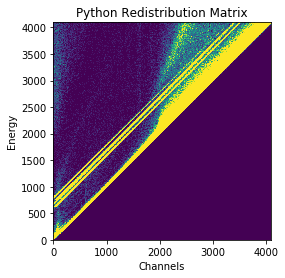

In [9]:
from matplotlib.colors import Normalize

fig,axs = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,4))

# Redistribution matrix [counts per photon]
## Python rdm
axs.imshow(mat_array, aspect=1, origin='lower', norm=Normalize(vmin=0,vmax=0.00005))
axs.set_title('Python Redistribution Matrix')
axs.set_ylabel('Energy')
axs.set_xlabel('Channels')
plt.show()

# Total Spectral Response SRM = rmf*arf [counts per photon * cm ^2]

In [10]:
srm = nu_spec.make_srm(rmf_matrix=mat_array, arf_array=eff_area)

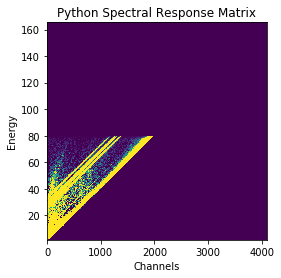

In [11]:
from matplotlib.colors import LogNorm

fig,axs = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,4))
axs.imshow(srm, aspect=len(srm[0,:])/channel[-1], origin='lower', norm=Normalize(vmax=0.0005), extent=[0, len(srm[0,:]), channel[0], channel[-1]])
axs.set_title('Python Spectral Response Matrix')
axs.set_ylabel('Energy')
axs.set_xlabel('Channels')
plt.show()

# Define some models to fit

In [12]:
def test_model_powerlaw(energies, constant, power):
    return constant*np.array(energies, dtype=float)**-power

# constant is [photon s^-1 keV^-1 cm^-2]
# power is the spectral index

In [13]:
def test_model_brokenpowerlaw(energies, constant, power1, brk, power2):
    model_spec = []
    for e in energies:
        if e < brk:
            model_spec.append(constant*e**(-power1))
        else:
            model_spec.append(constant*e**(power2-power1)*e**(-power2))
    return model_spec

## Get modelled counts spectrum

Have how the physical photon (y-axis) is converted and sorted into the actual detector channels (x-axis) - Spec Resp

Find the number of photons at each energy (photon spectrum) and multiply each energy seen by the number of photons for 
For that energy range to get a 2D matrix of the counts produced by one energy across several detector channels.

Sum the columns (total counts seen by the detector from multiple energy ranges) to get the observed count spectrum

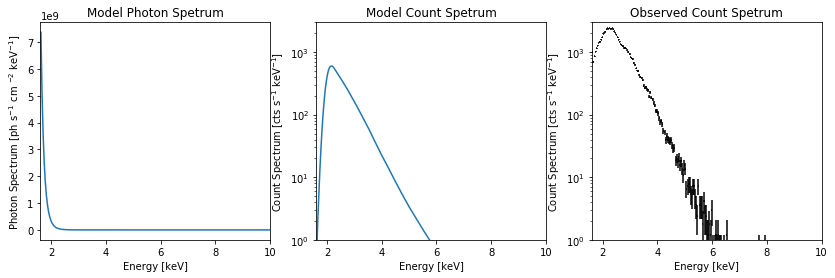

In [14]:
fig,axs = plt.subplots(1,3, sharex=True, figsize=(14,4))
axs[0].plot(channel, 
            test_model_powerlaw(channel, 20**10, 15))
axs[0].set_title('Model Photon Spetrum')
axs[0].set_xlabel('Energy [keV]')
axs[0].set_ylabel('Photon Spectrum [ph s$^{-1}$ cm $^{-2}$ keV$^{-1}$]')
axs[0].set_xlim([1.6,10])

axs[1].plot(channel, 
            nu_spec.make_model(channel, test_model_powerlaw, parameters=[20**4, 10], srm=srm))
axs[1].set_title('Model Count Spetrum')
axs[1].set_xlabel('Energy [keV]')
axs[1].set_ylabel('Count Spectrum [cts s$^{-1}$ keV$^{-1}$]')
axs[1].set_ylim([1.,3000])
axs[1].set_yscale('log')

axs[2].errorbar(channel, 
             counts, 
             xerr=channel_error, 
             yerr=counts_error, 
             color='k', 
             fmt='.',
             markersize=0.01)
axs[2].set_title('Observed Count Spetrum')
axs[2].set_xlabel('Energy [keV]')
axs[2].set_ylabel('Count Spectrum [cts s$^{-1}$ keV$^{-1}$]')
axs[2].set_ylim([1.,3000])
axs[2].set_yscale('log')

plt.show()

## Non-Linear Least squares Fitting

# Try Maximum likelihood approach too

## Likelihood

In [15]:
def minus_log_poisson_likelihood(mod_const_and_power, obs_counts, channel, total_response):
    # allow the model to be varied to minimize -ln(L)
    
    mu = nu_spec.make_model(channel, 
                    test_model_powerlaw, 
                    [mod_const_and_power[0], mod_const_and_power[1]], 
                    total_response)
    
    # mu number of counts predicted
    # x is the number of counts
    likelihoods = []
    for i in range(len(obs_counts)):
        l = obs_counts[i]*( np.log(mu[i]/obs_counts[i]) + 1 ) - mu[i]
        l = l if np.isfinite(l) else 0 ## if there are no counts, I don't want it to affect the result
        likelihoods.append(l)
    return -np.sum(likelihoods)

# Maximise the Likelihood

In [16]:
initial = [20**4, 10]
methods = [None, 'Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'COBYLA', 'TNC', 'SLSQP'] 
method = methods[1]
# L-BFGS-B and COBYLA change the fit the most compared to the others
soln = minimize(minus_log_poisson_likelihood, initial, args=(counts[:75], channel[:75], srm), method=method)

# Work out residuals of Max. Likelihood fit to get Chi^2

In [17]:
# maximum likelihood
model_cts_minimize = nu_spec.make_model(channel, test_model_powerlaw, [*soln.x], srm)
res_lh = [(counts[i] - model_cts_minimize[i])/counts_error[i] if counts_error[i]>0 else 0 for i in range(len(counts_error))]
print('Constant and power law: ', soln.x)
print('Minimized log(L): ', minus_log_poisson_likelihood(soln.x, counts[:75], channel[:75], srm))
print('Chi^2 from Minimized log(L): ', np.sum(np.array(res_lh)**2))

Constant and power law:  [1.48564368e+06 1.06274450e+01]
Minimized log(L):  14181.551857723587
Chi^2 from Minimized log(L):  14966.197240874493


# Plot results

In [28]:
soln.x

array([1.48564368e+06, 1.06274450e+01])

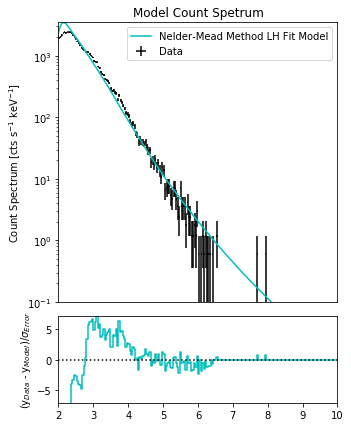

In [18]:
fig, axs = plt.subplots(figsize=(5,7))
## plot fits
axs.plot(channel, model_cts_minimize, label=str(method)+' Method LH Fit Model', color='c')
axs.set_title('Model Count Spetrum')
axs.set_xlabel('Energy [keV]')
axs.set_ylabel('Count Spectrum [cts s$^{-1}$ keV$^{-1}$]')
axs.set_ylim([0.1,3500])
axs.set_yscale('log')
axs.xaxis.set_tick_params(labelbottom=False)
axs.get_xaxis().set_visible(False)

## plot data
axs.errorbar(channel, counts,xerr=channel_error, yerr=counts_error, color='k', fmt='.',markersize=0.01, label='Data')
plt.legend()

#residuals plotting
divider = make_axes_locatable(axs)
res = divider.append_axes('bottom', 1.2, pad=0.2, sharex=axs)
res.plot(channel, res_lh, drawstyle='steps-mid', color='c')
res.axhline(0, linestyle=':', color='k')
res.set_xlim([2,10])
res.set_ylim([-7,7])
res.set_ylabel('(y$_{Data}$ - y$_{Model}$)/$\sigma_{Error}$')

axs.set_xlim([2,10])
plt.show()


# MCMC Maximum likelihood result it

In [36]:
def prior(constant, power):
    if 10**5 < constant <10**7 and 8 < power < 12:
        return 0.0
    return -np.inf

In [37]:
def prob(mod_const_and_power, obs_counts, channel, total_response):
    lp = prior(*mod_const_and_power)
    if not np.isfinite(lp):
        return -np.inf
    ## 'lp -' as its the negative log
    return lp - minus_log_poisson_likelihood(mod_const_and_power, obs_counts, channel, total_response)

In [40]:
ndim, nwalkers = 2, 1000
pos = [soln["x"] + [1000*np.random.randn(1)[0], 0.1*np.random.randn(1)[0]] for i in range(nwalkers)]

In [41]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, prob, args=(counts[:75], channel[:75], srm))
sampler.run_mcmc(pos, 500, progress=True);

100%|██████████| 500/500 [07:31<00:00,  1.11it/s]


# Get corner plot of the MCMC

In [42]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

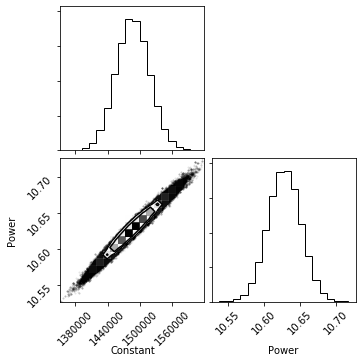

In [43]:
fig = corner.corner(samples, labels=["Constant", "Power"])

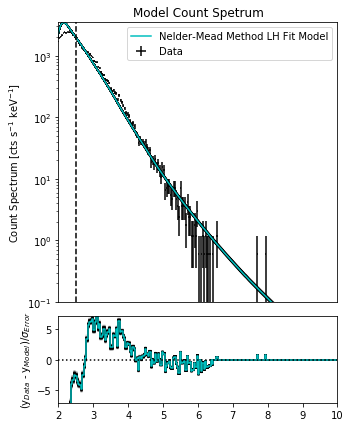

In [45]:
fig,axs = plt.subplots(figsize=(5,7))

# get residuals for all the trys
for_ress = []
for constant, power in samples[np.random.randint(len(samples), size=200)]:
    model_cts_try = nu_spec.make_model(channel, test_model_powerlaw, [constant, power], srm)
    for_ress.append(model_cts_try)
    plt.plot(channel, model_cts_try, color="k", alpha=0.1)

# plot the maximised likelihood solution
axs.plot(channel, model_cts_minimize, label=str(method)+' Method LH Fit Model', color='c')
axs.set_title('Model Count Spetrum')
axs.set_xlabel('Energy [keV]')
axs.set_ylabel('Count Spectrum [cts s$^{-1}$ keV$^{-1}$]')
axs.set_ylim([0.1,3500])
axs.set_yscale('log')
axs.xaxis.set_tick_params(labelbottom=False)
axs.get_xaxis().set_visible(False)

# plot data
axs.errorbar(channel, counts,xerr=channel_error, yerr=counts_error, color='k', fmt='.',markersize=0.01, label='Data')
axs.axvline(x=2.5, c='k', linestyle='--')
plt.legend()

#residuals plotting
divider = make_axes_locatable(axs)
res = divider.append_axes('bottom', 1.2, pad=0.2, sharex=axs)
for m in for_ress:
    r = [(counts[i] - m[i])/counts_error[i] if counts_error[i]>0 else 0 for i in range(len(counts_error))]
    res.plot(channel, r, drawstyle='steps-mid', color='k', alpha=0.1)
res.plot(channel, res_lh, drawstyle='steps-mid', color='c')
res.axhline(0, linestyle=':', color='k')
res.set_xlim([2,10])
res.set_ylim([-7,7])

res.set_ylabel('(y$_{Data}$ - y$_{Model}$)/$\sigma_{Error}$')

#fig.text(.5, .05, txt, ha='center')
axs.set_xlim([2,10])
plt.show()